# Part 1 ‑ Exploratory data analysis

The attached *logins.json* file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15­ minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [45]:
# Import required packages.
import pandas as pd
import json
import datetime
import matplotlib.pyplot as plt
import numpy as np
import math
import datetime
import dateutil
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [2]:
# Read in json file as DataFrame.
json_df = pd.read_json('logins.json').sort_values('login_time').reset_index(drop=True)

In [15]:
# Group all timestamp data into 15 minute intervals.
t_delta = datetime.timedelta(minutes = 15)

time_list = []

json_df_copy = json_df.copy()

while len(json_df_copy) > 0:
    max_time = json_df_copy.loc[json_df_copy.index.min()][0] + t_delta
    list1 = [time for time in json_df_copy.login_time if time < max_time]
    json_df_copy = json_df_copy.drop(json_df_copy.index[:len(list1)])
    time_list.append(list1)

In [34]:
# Create DataFrame of the count of timestamps per 15 minute intervals.
count_df = pd.DataFrame({'time_cut': [str(max(list_)) for list_ in time_list], 
                         'count': [len(count) for count in time_list]}).set_index('time_cut')

count_df.head()

,count
time_cut,
1970-01-01 20:26:21,8
1970-01-01 20:43:59,9
1970-01-01 20:59:59,7
1970-01-01 21:20:53,4
1970-01-01 21:29:19,1


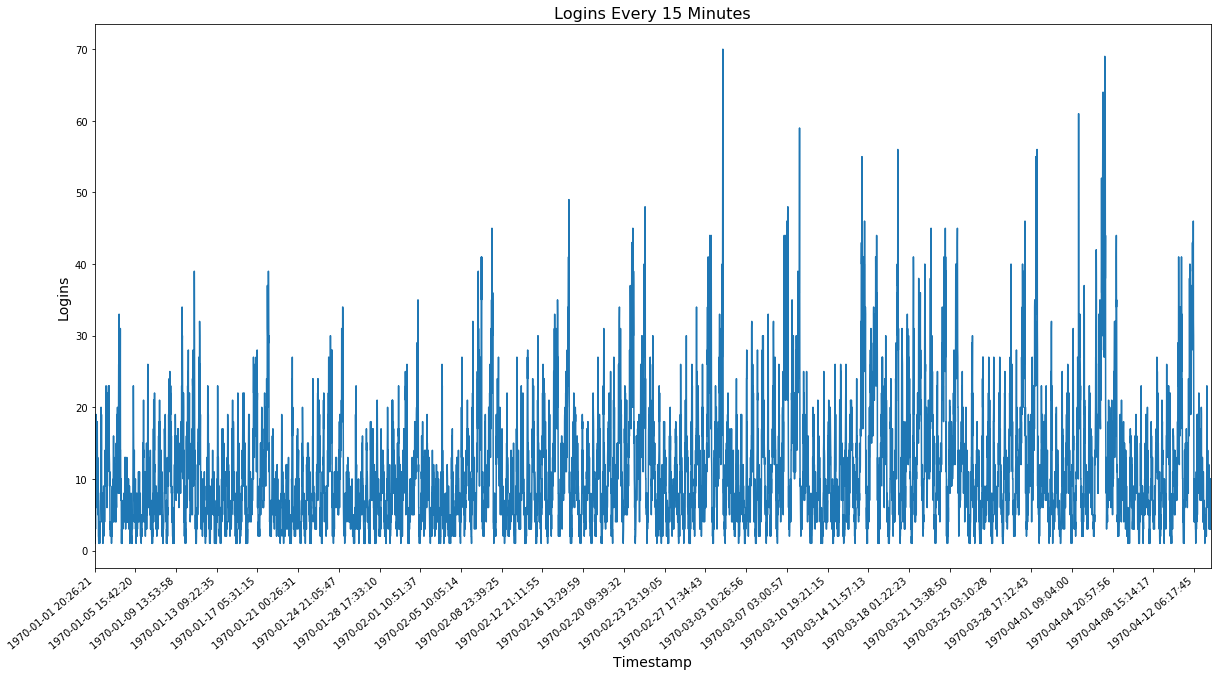

Most Logins Per 15 Minute Interval
Interval Start: 1970-03-01 04:35:37
Interval End: 1970-03-01 04:50:37
Logins: 70


In [32]:
# Plot logins per 15 minute intervals.
count_df.plot(figsize=(20,10), 
              rot=40, 
              xticks=(np.arange(0, len(count_df), 300)), 
              legend=False)
plt.xticks(ha='right')
plt.xlabel('Timestamp', fontsize=14)
plt.ylabel('Logins', fontsize=14)
plt.title('Logins Every 15 Minutes', fontsize=16)
plt.show()

# Calcualate interval with highest logins and the login total.
max_count = int(count_df['count'].max())

for index in count_df.index:
    if count_df.loc[index].item() == max_count:
        interval_end = index
        
interval_start = str(datetime.datetime.strptime(interval_end, "%Y-%m-%d %H:%M:%S") - t_delta)

print('Most Logins Per 15 Minute Interval')
print('Interval Start: ' + interval_start)
print('Interval End: ' + interval_end)
print('Logins: ' + str(max_count))

The chart illustrates a pattern in which logins peak at one particular day of the week, then decline only to gradually climb back up to a new peak.  This indicates that logins are regularly high during certain days of the week and low during others.  Overall, usage seems to be increasing since the peaks are rising and the overall spread of the data is widers, particularly throughout the month of March.

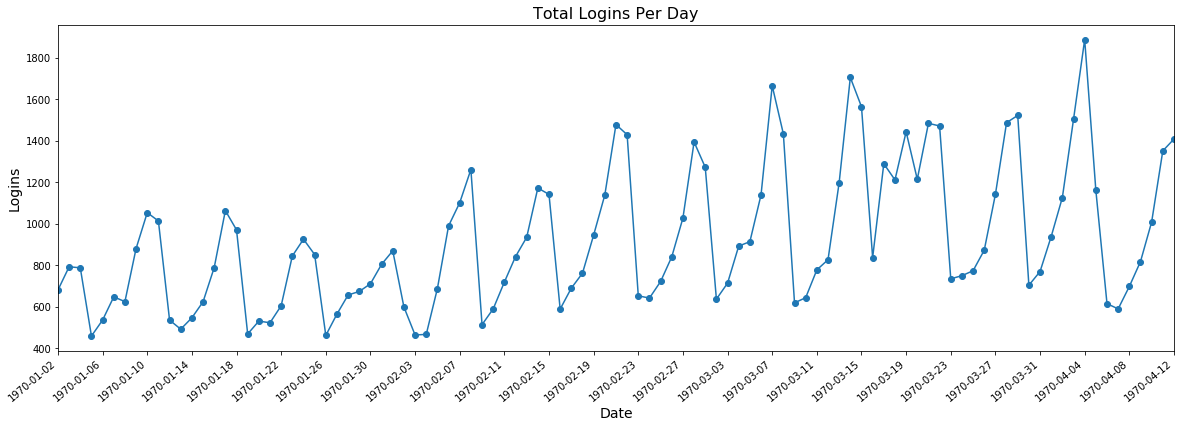

Date With Most Logins
Date: 1970-04-04
Logins: 1889


In [26]:
# Plot logins per day.
date_time_split = [str(date_time).split(' ') for date_time in json_df.login_time]

date = [datetime[0] for datetime in date_time_split]

daily_total = pd.Series(date).value_counts().sort_index()
daily_total = daily_total.drop([daily_total.index.min(), daily_total.index.max()])

daily_total.plot(figsize=(20,6), 
                 rot=40, 
                 xticks=(np.arange(0, len(daily_total), 4)), 
                 marker='o', 
                 legend=False)
plt.xticks(ha='right')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Logins', fontsize=14)
plt.title('Total Logins Per Day', fontsize=16)
plt.show()

# Calcualate date with highest logins and the login total.
max_count = int(daily_total.max())

for index in daily_total.index:
    if daily_total.loc[index].item() == max_count:
        date_of_max = index

print('Date With Most Logins')
print('Date: ' + date_of_max)
print('Logins: ' + str(max_count))

This plot of logins per day is a simplified represenation of the previous chart.  Here the ebb and flow of logins are easier to see as is the increase in logins over time.

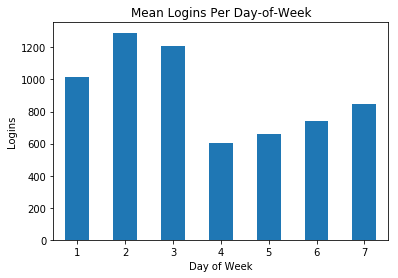

Day of the Week with Most Mean Logins
Day: 2
Mean Logins: 1291.8



In [28]:
# Plot logins per day of the week.
day_of_week = daily_total.to_frame()

days = [i for i in range(1,8)] * 15
days = days[:len(day_of_week)]

day_of_week.index = days

day_of_week = day_of_week.groupby(days).mean()
day_of_week.plot(kind='bar',rot=0, legend=False)
plt.xlabel('Day of Week')
plt.ylabel('Logins')
plt.title('Mean Logins Per Day-of-Week')
plt.show()

# Calcualate day of the week with highest logins and the login total.
max_mean_days = day_of_week.max().item()

for index in day_of_week.index:
    if day_of_week.loc[index].item() == max_mean_days:
        day_of_max = index
        
print('Day of the Week with Most Mean Logins')
print('Day: ' + str(day_of_max))
print('Mean Logins: ' + str(max_mean_days))
print('')

Since I do not know the actual days of the week for these time stamps, I simply used days 1-7.  Logins peak at day 2, dip slightly into day 3 an drop dramatically ito day 4.  From there, logins gradaully increase throughout the week until peaking again at day 2.

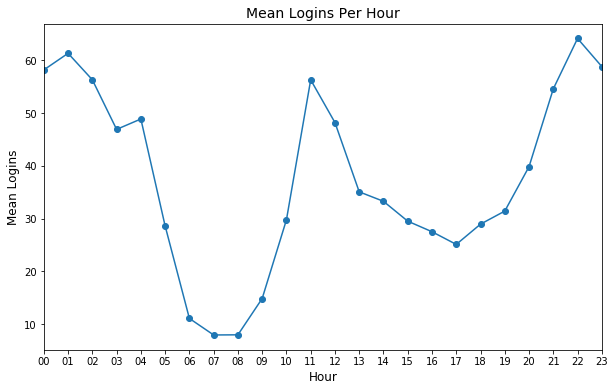

Hour With Highest Mean Logins
Hour: 22
Mean Logins: 64.14563106796116

Hour With Lowest Mean Logins
Hour: 07
Mean Logins: 7.912621359223301


In [31]:
# Plot logins per hour of the day.
hours = [hourstamp[1][:2] for hourstamp in date_time_split]

date_hours = pd.DataFrame({'date': date, 
                           'hour': hours})
date_hours['n'] = 1

date_hours_pivot = date_hours.pivot_table(values='n', 
                                          index='date', 
                                          columns='hour', 
                                          aggfunc=np.sum, 
                                          fill_value=0)

date_hours_pivot.mean().plot(figsize=(10,6), 
                             xticks=(np.arange(0, len(date_hours_pivot.columns))), 
                             marker='o', 
                             legend=False)
plt.xlabel('Hour', fontsize=12)
plt.ylabel('Mean Logins', fontsize=12)
plt.title('Mean Logins Per Hour', fontsize=14)
plt.show()

# Calcualate hour of the day with highest logins and the login total.
max_mean = date_hours_pivot.mean().max()

for index in date_hours_pivot.mean().index:
    if date_hours_pivot.mean().loc[index].item() == max_mean:
        hour_of_max = index
        
print('Hour With Highest Mean Logins')
print('Hour: ' + hour_of_max)
print('Mean Logins: ' + str(max_mean))
print('')

min_mean = date_hours_pivot.mean().min()

for index in date_hours_pivot.mean().index:
    if date_hours_pivot.mean().loc[index].item() == min_mean:
        hour_of_min = index
        
print('Hour With Lowest Mean Logins')
print('Hour: ' + hour_of_min)
print('Mean Logins: ' + str(min_mean))

On average, login activity is greatest between 9PM and 2AM, peaking at 10PM.  After 1AM, logins steadily decline until dropping dramatically between 4AM and 6AM.  Activity is is at its lowest between 7AM and 8AM until it rises dramatically up through 11AM.  From there, activity declines until around 5PM when it starts to pick up until peaking at 10PM.

**Summary:** 
* Logins are increasing over time.  
* Usage is highest on days 2 and 3 and lowest on day 4.
* Usage is highest bewteen the hours of 9PM and 2AM and lowest between the hours of 6AM and 9AM.

# Part 2 ‑ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. However, a toll bridge, with a two ­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

I think the key success indicator would be the volume of toll reimbursement granted by Ultimate as it is most directly tied to the hypothesis that the tolls on the bridge are preventing drivers from serving both cities.  If the volume of reimbursement is low relative to the amount of eligible drivers, then there are other factors preventing drivers from serving both cities.

2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
 1. How you will implement the experiment
 2. What statistical test(s) you will conduct to verify the significance of the observation
 3. How you would interpret the results and provide recommendations to the city operations team along with any caveats.

This sounds like a use case for a classic A/B test.  First, I would select a timeframe of 3-4 weeks to capture a decent sample of weekday activity since the two cities have complementary circadian rhythms.  I would want to find this timeframe in the summer months to minimize weather impact on driving conditions as well as avoid any major holidays that would affect travel in the area.  I would also try to plan around any major events that would be taking place in the either city.  Once I had the timeframe decided, I would determine a pool of drivers whose activity is closest to the mean so there would be room for increased activity under the conditions of the experiment.  I offer full toll reimbursement to 5-10% of the drivers in this designated pool for one week, and a different 5-10% of the drivers the next and so on for the duation of the experiment in order to generate the most samples.  During this time, we track the reimbursement being provided to the drivers as well as if there is any increase in driver activity during the entire experiment.  The complementary circadian rhythms of the two cities provides excellent conditions for such an experiment.  Linear regression would be able to indicate whether or not / the degress to which increased activity in either city were correlated to the occurences of toll reimbursement.  If weekday driver activity in either city increases during its busy hours while the other remains relatively steady AND there is a high correlation between this increase and the toll reimbursement, I would conclude that removing the barrier of the bridge tolls was an affective measure to improve engagement.  If activity did not increase, or there was a low volume of toll reimburesment or a low correlation between the two, then there are potentially other factors besides the tolls that are limiting drivers from serving both cities.

# Part 3 ‑ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if theywere “active” (i.e. took a trip) in the preceding 30 days. We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate. The data is in the attached file *ultimate_data_challenge.json.* See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
 1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
 2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
 3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­ term rider retention (again, a few sentences will suffice).

In [36]:
# Read in json file as DataFrame
json_df = pd.read_json('ultimate_data_challenge.json')

ValueError: Expected object or value

That did not work, so trying another approach.

In [2]:
# Read in json file as text file and convert DataFrame
file=open('ultimate_data_challenge.json', 'r')

file_content=file.read()

file.close()

data=json.loads(file_content)

df=pd.DataFrame(data) 

df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


There we go.

In [3]:
df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


Some useful insight into the raw data.  There is obviously missing data in **avg_rating_by_driver** and **avg_rating_of_driver** columns.

In [4]:
#Determine if / which columns have missing data.
null_data_columns = []

for column in df.columns.values:
    print(column + ' : ' + str(df[column].isna().any()))
    if df[column].isna().any() == True:
        null_data_columns.append(column)

avg_dist : False
avg_rating_by_driver : True
avg_rating_of_driver : True
avg_surge : False
city : False
last_trip_date : False
phone : True
signup_date : False
surge_pct : False
trips_in_first_30_days : False
ultimate_black_user : False
weekday_pct : False


Three columns contain missing data: **avg_rating_by_driver**, **avg_rating_of_driver** and **phone**.

In [5]:
#Determine how much useful data there is in each column with mising data.
for column in null_data_columns:
    print(column + ' : ' + str(df[column].value_counts().sum()))

avg_rating_by_driver : 49799
avg_rating_of_driver : 41878
phone : 49604


**avg_rating_of_driver** has the most missing data.  Since I am would be retaining >80% of the dataset, I will remove all samples with missing data.

In [6]:
# Add a column for whether or not a user is active according to the definition in the directions.
max_date = datetime.datetime.strptime(df['last_trip_date'].max(), '%Y-%m-%d') - dateutil.relativedelta.relativedelta(days=+30)

retention_list = [max_date < datetime.datetime.strptime(df['last_trip_date'].loc[i], '%Y-%m-%d') for i in range(len(df))]   

retention_df = df.copy()
retention_df['active'] = retention_list

retention_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,True
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,False
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,False
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,True
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,False


In [7]:
# Remove all missing data.
clean_retention_df = retention_df.copy()
clean_retention_df = clean_retention_df.dropna(axis=0, how='any')
clean_retention_df = clean_retention_df.reset_index(drop=True)

active_df = clean_retention_df[clean_retention_df.active == True].copy()
not_active_df = clean_retention_df[clean_retention_df.active == False].copy()

# Print active and inactive account totals.
print('Active Accounts: ' + str(len(active_df)))
print('Inactive Accounts: ' + str(len(not_active_df)))

# Show difference between active and inactive users.
(active_df.describe() - not_active_df.describe())

Active Accounts: 16608
Inactive Accounts: 24837


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,-8229.000000,-8229.000000,-8229.000000,-8229.000000,-8229.000000,-8229.000000,-8229.000000
mean,-0.910277,-0.028466,-0.013722,-0.001989,0.352066,1.681994,1.887139
std,-1.557737,-0.170522,-0.124905,-0.086319,-6.647323,2.243893,-11.793673
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.260000,-0.200000,0.000000,0.000000,0.000000,0.000000,18.100000
50%,-0.210000,-0.200000,-0.200000,0.010000,2.700000,1.000000,-2.000000
75%,-1.590000,0.000000,0.000000,0.100000,14.300000,3.000000,-16.700000
max,-0.350000,0.000000,0.000000,-3.500000,0.000000,52.000000,0.000000


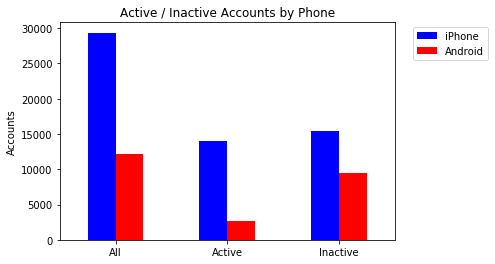

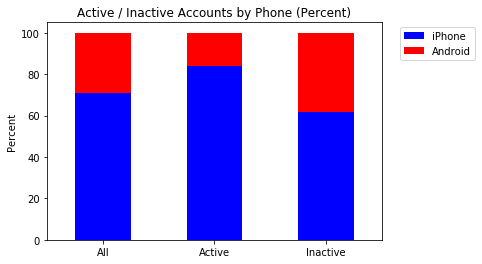

In [8]:
# Plot account status by phone.
phone_df = pd.concat([clean_retention_df['phone'].value_counts(),
                      active_df.phone.value_counts(),
                      not_active_df.phone.value_counts()],
                     axis=1)
phone_df.columns = ['All', 'Active', 'Inactive']

phone_percent_df = phone_df/phone_df.sum()*100
phone_percent_df.columns = ['All', 'Active', 'Inactive']


phone_df.transpose().plot(kind='bar', color=['blue', 'red'], rot=0)
plt.title('Active / Inactive Accounts by Phone')
plt.ylabel('Accounts')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

phone_percent_df.transpose().plot(kind='bar', color=['blue', 'red'], rot=0, stacked=True)
plt.title('Active / Inactive Accounts by Phone (Percent)')
plt.ylabel('Percent')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

Overall, iPhones are far more prevalent amongst the sample accounts.  Yet, the percentage of Android users amongst the inactive accounts is higher than the active accounts and all users.  Maybe there is an issue with the Android platform? 

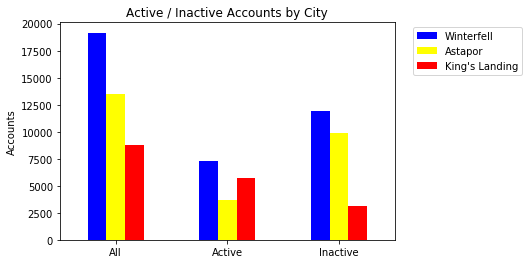

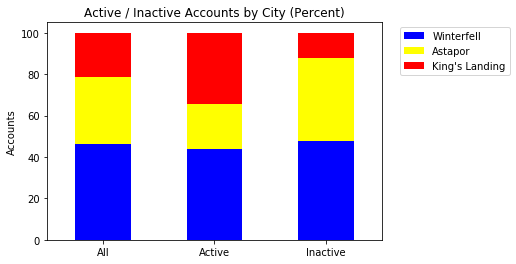

In [9]:
# Plot account status by city.
city_df = pd.concat([clean_retention_df.city.value_counts(), 
                     active_df.city.value_counts(), 
                     not_active_df.city.value_counts()], 
                    axis=1, 
                    sort=False)

city_df.columns = ['All', 'Active', 'Inactive']

city_percent_df = city_df/city_df.sum()*100
city_percent_df.columns = ['All', 'Active', 'Inactive']

city_df.transpose().plot(kind='bar', color=['blue', 'yellow', 'red'], rot=0)
plt.title('Active / Inactive Accounts by City')
plt.ylabel('Accounts')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

city_percent_df.transpose().plot(kind='bar', color=['blue', 'yellow', 'red'], rot=0, stacked=True)
plt.title('Active / Inactive Accounts by City (Percent)')
plt.ylabel('Accounts')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

Winterfell has more users than the the other two citys, and the percentage of active and inactive accounts are close to the total percentage of accounts in that city.  However, according to the percentages, Astapor has a much higher propotion of inactive accounts, so maybe there is an issue with the service or engagement in Astapor.

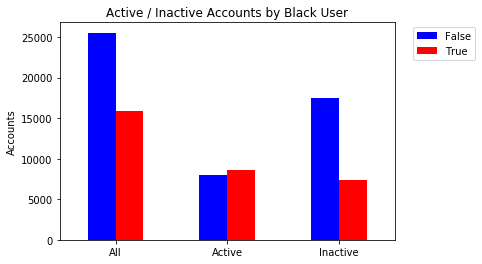

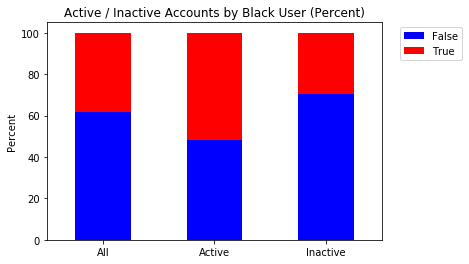

In [10]:
# Plot account status by city.
black_user_df = pd.concat([clean_retention_df.ultimate_black_user.value_counts(),
                        active_df.ultimate_black_user.value_counts(),
                        not_active_df.ultimate_black_user.value_counts()],
                       axis=1,
                       sort=False)
black_user_df.columns = ['All', 'Active', 'Inactive']

black_user_percent_df = black_user_df/black_user_df.sum()*100
black_user_percent_df.columns = ['All', 'Active', 'Inactive']

black_user_df.transpose().plot(kind='bar', color=['blue', 'red'], rot=0)
plt.title('Active / Inactive Accounts by Black User')
plt.ylabel('Accounts')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

black_user_percent_df.transpose().plot(kind='bar', color=['blue', 'red'], rot=0, stacked=True)
plt.title('Active / Inactive Accounts by Black User (Percent)')
plt.ylabel('Percent')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

There appears to be a greater proportion of active accounts that used Ultimate Black than inactive accounts.  Assuming Black is some sort of premium service, it is not surprising that accounts that have gone inactive would not have used it.

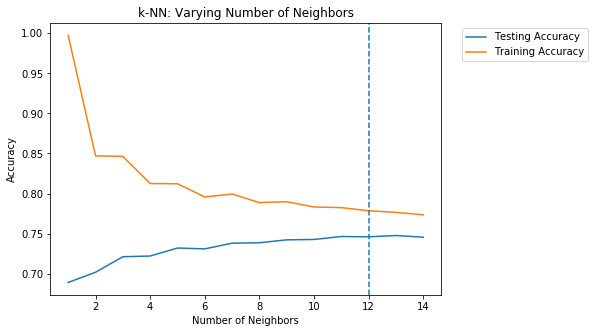

Optimal k-value: 12

Classification Report: 
              precision    recall  f1-score   support

           0       0.78      0.81      0.79      7431
           1       0.70      0.66      0.68      5003

    accuracy                           0.75     12434
   macro avg       0.74      0.73      0.74     12434
weighted avg       0.75      0.75      0.75     12434

Accuracy Score: 0.75

                  Feature    Chi-Square
7  trips_in_first_30_days  10789.629257
0                avg_dist   1510.412415
8     ultimate_black_user   1260.179510
5                   phone    694.759836
9             weekday_pct    578.643607
4                    city    165.491556
6               surge_pct    138.632946
1    avg_rating_by_driver      1.688437
2    avg_rating_of_driver      0.407246
3               avg_surge      0.036684


In [153]:
# Encode strings data as integers.
LE = preprocessing.LabelEncoder()

encoded_dic={}

for col in clean_retention_df.columns:
    if clean_retention_df[col].dtype != 'float64' and clean_retention_df[col].dtype != 'int64':
        encoded=LE.fit_transform(clean_retention_df[col].values)
        encoded_dic[col] = encoded
        
encoded_df = pd.DataFrame(encoded_dic)

new_retention_df = clean_retention_df.drop(columns=encoded_df.columns).copy()

numeric_retention_df = pd.concat([new_retention_df, encoded_df], axis=1)
numeric_retention_df = numeric_retention_df[retention_df.columns]
numeric_retention_df = numeric_retention_df.drop(['last_trip_date', 'signup_date'], axis=1)

# Split training / test sets.
X = numeric_retention_df.drop(['active'], axis=1)
y = numeric_retention_df.active

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) 

# Determine best k-value and capture best kNN results.
neighbors = np.arange(1, 15)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

best_score = 0

for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree', n_jobs = -1)
    knn.fit(X_train, y_train)
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test)
    y_pred = knn.predict(X_test)
    if accuracy_score(y_test, y_pred) > best_score:
            best_score = accuracy_score(y_test, y_pred)
            best_k = i
            best_y_pred = y_pred

# Plot training / testing accuracy for k-values and print classification reports.
plt.figure(figsize=(7,5))
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.axvline(best_k, linestyle='--')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

print('Optimal k-value: ' + str(best_k))
print('')
print('Classification Report: ')
print(classification_report(y_test, best_y_pred))
print('Accuracy Score: ' + str(round(best_score, 2)))

# Determine feature significance and print results.
bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Chi-Square']
print('')
print(featureScores.sort_values('Chi-Square', ascending=False))  

kNN with 12 neighbors yields an accuracy of 75%, which is not too bad.  Testing the feature importance determines **trips_in_first_30_days** to be the most significant factor in predicting user retention.

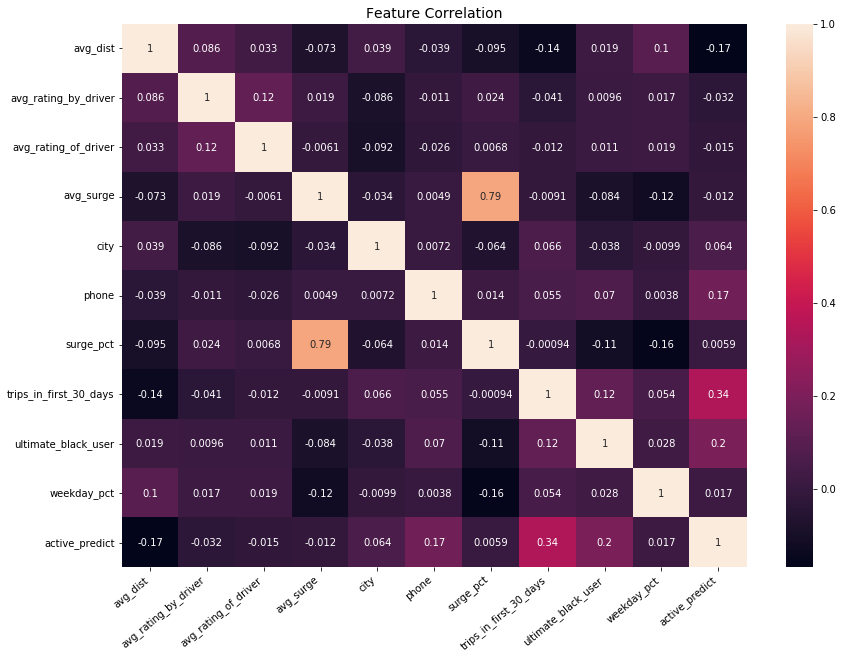

Feature Correlation for active_predict:
trips_in_first_30_days    0.336328
ultimate_black_user       0.198072
phone                     0.168630
city                      0.063691
weekday_pct               0.016868
surge_pct                 0.005858
avg_surge                -0.012076
avg_rating_of_driver     -0.015004
avg_rating_by_driver     -0.031528
avg_dist                 -0.168780
Name: active_predict, dtype: float64


In [154]:
# Create DataFrame of kNN predictions.
final_df = pd.DataFrame(X_test)
final_df.columns = numeric_retention_df.drop(['active'], axis=1).columns
final_df['active_predict'] = best_y_pred

# Plot and print feature correlation to retention predictions.
plt.figure(figsize=(14,10))
sns.heatmap(final_df.corr(), annot=True)
plt.yticks(va='center', rotation=0)
plt.xticks(ha='right', rotation=40)
plt.title('Feature Correlation', fontsize=14)
plt.show()

print('Feature Correlation for active_predict:')
print(final_df.corr().active_predict.sort_values(ascending=False).drop('active_predict'))

The results here also confirm that **trips_in_first_30_days** has the highest correlation to **active_predict** values.

In [155]:
# Convert numerically encoded data back to text.
dic = {}

for column in encoded_df.drop(['last_trip_date', 'signup_date'], axis=1).columns:
    dic[column] = {}
    for i in range(len(encoded_df[column])):
        dic[column].update({encoded_df[column][i]: clean_retention_df[column][i]})
        
for dic_ in dic:
    try:
        final_df[dic_] = final_df[dic_].map(dic[dic_])
    except:
        continue

final_df['active_predict'] = final_df['active_predict'].map(dic['active'])


print(final_df[['trips_in_first_30_days', 'active_predict']].groupby('active_predict').mean())
print('')
print(final_df[['avg_dist', 'active_predict']].groupby('active_predict').mean())

                trips_in_first_30_days
active_predict                        
False                         1.552266
True                          4.484048

                avg_dist
active_predict          
False           6.186138
True            4.381215


On average, users predicted to be active take more trips for shorter distances within their first 30 days on the service than users predicted to be inactive.

**Summary:** 
* Users that take shorter, more frequent trips are more likely to remain active after six months on the service.  Perhaps Ulitmate could offer incentives to new users to use the service more often.
* Users that use Ultimate Black in their first 30 days on the service are more likely to remain active after six months on the service.  Ultimate could offer new users special promotions to experience Black.
* iPhone users are more prevalent overall, but especially amongst retained users.  Perhaps there is an issue with the Android platform.